Lambda School Data Science

*Unit 2, Sprint 1, Module 2*

---

# Regression 2

## Assignment

You'll continue to **predict how much it costs to rent an apartment in NYC,** using the dataset from renthop.com.

- ✔️ Do train/test split. Use data from April & May 2016 to train. Use data from June 2016 to test.
- ✔️ Engineer at least two new features. (See below for explanation & ideas.)
- ✔️ Fit a linear regression model with at least two features.
- ✔️ Get the model's coefficients and intercept.
- ✔️ Get regression metrics RMSE, MAE, and $R^2$, for both the train and test data.
- [ ] What's the best test MAE you can get? Share your score and features used with your cohort on Slack!
- [ ] As always, commit your notebook to your fork of the GitHub repo.


#### [Feature Engineering](https://en.wikipedia.org/wiki/Feature_engineering)

> "Some machine learning projects succeed and some fail. What makes the difference? Easily the most important factor is the features used." — Pedro Domingos, ["A Few Useful Things to Know about Machine Learning"](https://homes.cs.washington.edu/~pedrod/papers/cacm12.pdf)

> "Coming up with features is difficult, time-consuming, requires expert knowledge. 'Applied machine learning' is basically feature engineering." — Andrew Ng, [Machine Learning and AI via Brain simulations](https://forum.stanford.edu/events/2011/2011slides/plenary/2011plenaryNg.pdf) 

> Feature engineering is the process of using domain knowledge of the data to create features that make machine learning algorithms work. 

#### Feature Ideas
- Does the apartment have a description?
- How long is the description?
- How many total perks does each apartment have?
- Are cats _or_ dogs allowed?
- Are cats _and_ dogs allowed?
- Total number of rooms (beds + baths)
- Ratio of beds to baths
- What's the neighborhood, based on address or latitude & longitude?

## Stretch Goals
- [ ] If you want more math, skim [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf),  Chapter 3.1, Simple Linear Regression, & Chapter 3.2, Multiple Linear Regression
- [ ] If you want more introduction, watch [Brandon Foltz, Statistics 101: Simple Linear Regression](https://www.youtube.com/watch?v=ZkjP5RJLQF4)
(20 minutes, over 1 million views)
- [ ] Add your own stretch goal(s) !

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'
    
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [0]:
import numpy as np
import pandas as pd

# Read New York City apartment rental listing data
df = pd.read_csv(DATA_PATH+'apartments/renthop-nyc.csv')
assert df.shape == (49352, 34)

# Remove the most extreme 1% prices,
# the most extreme .1% latitudes, &
# the most extreme .1% longitudes
df = df[(df['price'] >= np.percentile(df['price'], 0.5)) & 
        (df['price'] <= np.percentile(df['price'], 99.5)) & 
        (df['latitude'] >= np.percentile(df['latitude'], 0.05)) & 
        (df['latitude'] < np.percentile(df['latitude'], 99.95)) &
        (df['longitude'] >= np.percentile(df['longitude'], 0.05)) & 
        (df['longitude'] <= np.percentile(df['longitude'], 99.95))]

---

In [3]:
df.head()

,bathrooms,bedrooms,created,description,display_address,latitude,longitude,price,street_address,interest_level,elevator,cats_allowed,hardwood_floors,dogs_allowed,doorman,dishwasher,no_fee,laundry_in_building,fitness_center,pre-war,laundry_in_unit,roof_deck,outdoor_space,dining_room,high_speed_internet,balcony,swimming_pool,new_construction,terrace,exclusive,loft,garden_patio,wheelchair_access,common_outdoor_space
0,1.5,3,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,40.7145,-73.9425,3000,792 Metropolitan Avenue,medium,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1.0,2,2016-06-12 12:19:27,,Columbus Avenue,40.7947,-73.9667,5465,808 Columbus Avenue,low,1,1,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1.0,1,2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-w...",W 13 Street,40.7388,-74.0018,2850,241 W 13 Street,high,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1.0,1,2016-04-18 02:22:02,Building Amenities - Garage - Garden - fitness...,East 49th Street,40.7539,-73.9677,3275,333 East 49th Street,low,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1.0,4,2016-04-28 01:32:41,Beautifully renovated 3 bedroom flex 4 bedroom...,West 143rd Street,40.8241,-73.9493,3350,500 West 143rd Street,low,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [4]:
# clean date
df['date'] = pd.to_datetime(df['created'], infer_datetime_format=True)
len(df['display_address'].unique())

8675

In [5]:
# NEW FEATURE IDEA 1: using lat/lon, how far is the apartment from the center?
lat_mean = df['latitude'].mean()
lon_mean = df['longitude'].mean()
center = np.array([lat_mean, lon_mean])
center

array([ 40.75076011, -73.97275997])

In [0]:
bucket = []
for i in range(df.shape[0]):
  row = df.iloc[i]
  xy = np.array([row['latitude'], row['longitude']])
  dist = np.linalg.norm(center - xy)
  bucket.append(dist)
df['dist_from_center'] = bucket

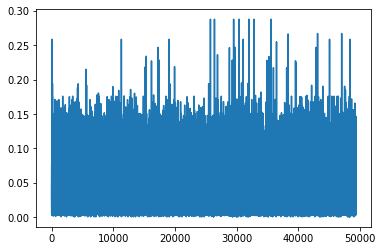

In [7]:
# just to make sure, let's plot this new feature
import matplotlib.pyplot as plt
plt.plot(df.index, df['dist_from_center'])
plt.show()

In [0]:
# NEW FEATURE IDEA 2: Ratio of unique words per description
bucket = []
for i in range(df.shape[0]):
  row = df.iloc[i]
  desc = row['description']
  if type(desc) != str:
    bucket.append(float('nan'))
  else:
    words = desc.split()
    if len(words) == 0:
      bucket.append(float('nan'))
    else:
      unique = list(set(words))
      ratio = len(unique) / len(words)
      bucket.append(ratio)
df['words_per_desc'] = bucket

KeyboardInterrupt: ignored

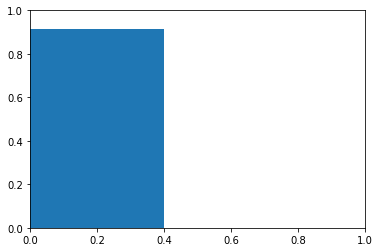

In [10]:
# Again, let's plot the feature to make sure it's working
plt.bar(df.index, df['words_per_desc'])
plt.show()

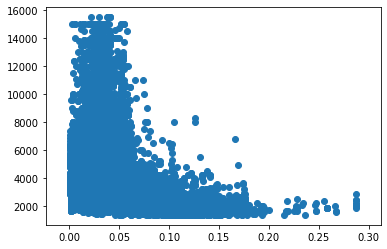

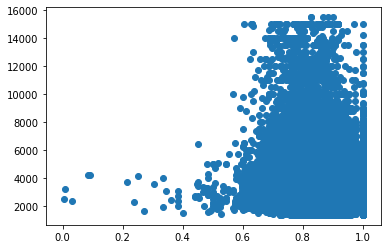

In [11]:
# Finally, let's plot the features against price
plt.scatter(df['dist_from_center'], df['price'])
plt.show()

plt.scatter(df['words_per_desc'], df['price'])
plt.show()
# hoo boy

In [12]:
df.head()

,bathrooms,bedrooms,created,description,display_address,latitude,longitude,price,street_address,interest_level,elevator,cats_allowed,hardwood_floors,dogs_allowed,doorman,dishwasher,no_fee,laundry_in_building,fitness_center,pre-war,laundry_in_unit,roof_deck,outdoor_space,dining_room,high_speed_internet,balcony,swimming_pool,new_construction,terrace,exclusive,loft,garden_patio,wheelchair_access,common_outdoor_space,date,dist_from_center,words_per_desc
0,1.5,3,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,40.7145,-73.9425,3000,792 Metropolitan Avenue,medium,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2016-06-24 07:54:24,0.047228,0.913978
1,1.0,2,2016-06-12 12:19:27,,Columbus Avenue,40.7947,-73.9667,5465,808 Columbus Avenue,low,1,1,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2016-06-12 12:19:27,0.044356,NaN
2,1.0,1,2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-w...",W 13 Street,40.7388,-74.0018,2850,241 W 13 Street,high,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2016-04-17 03:26:41,0.031406,0.880435
3,1.0,1,2016-04-18 02:22:02,Building Amenities - Garage - Garden - fitness...,East 49th Street,40.7539,-73.9677,3275,333 East 49th Street,low,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2016-04-18 02:22:02,0.005955,0.717949
4,1.0,4,2016-04-28 01:32:41,Beautifully renovated 3 bedroom flex 4 bedroom...,West 143rd Street,40.8241,-73.9493,3350,500 West 143rd Street,low,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2016-04-28 01:32:41,0.077001,0.805970


In [0]:
# do a train/test split: June 2016 as the cutoff
import datetime
X_cols = ['dist_from_center', 'words_per_desc']
y_col = 'price'
df['words_per_desc'] = df['words_per_desc'].fillna(0)
df_train = df[df['date'] < datetime.datetime(2016, 6, 1)]
df_test = df[df['date'] >= datetime.datetime(2016, 6, 1)]
X_train = df_train[X_cols]
X_test = df_test[X_cols]
y_train = df_train[y_col]
y_test = df_test[y_col]

In [14]:
# make our model
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [15]:
# get coefficients & intercept
co1 = model.coef_[0]
co2 = model.coef_[1]
b = model.intercept_
print(f'Coefficient 1: {co1}')
print(f'Coefficient 2: {co2}')
print(f'Y-Intercept: {b}')

Coefficient 1: -15309.29529925959
Coefficient 2: -497.05636012757674
Y-Intercept: 4566.603322367568


In [16]:
# score the model's predictions
y_pred = model.predict(X_test)

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import sqrt
print(f'RMSE: {sqrt(mean_squared_error(y_test, y_pred)):.2f}')
print(f'MAE: {mean_absolute_error(y_test, y_pred):.2f}')
print(f'R2: {r2_score(y_test, y_pred):.2f}')

RMSE: 1699.80
MAE: 1136.26
R2: 0.07


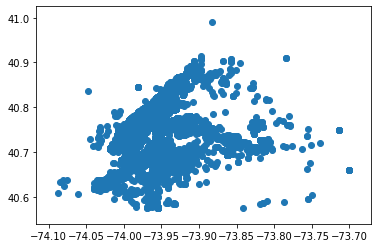

In [17]:
# let's try all that again, but being a bit more
# careful in the features we use
plt.scatter(df['longitude'], df['latitude'])
plt.show()

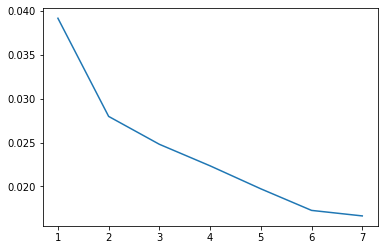

In [18]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
dists = []
df_xy = df[['longitude', 'latitude']]
x = range(1,8)
for k in x:
  model = KMeans(n_clusters=k)
  model.fit(df_xy)
  dists.append(sum(np.min(cdist(df_xy, model.cluster_centers_, 'euclidean'), axis=1)) / df_xy.shape[0])

plt.plot(x, dists)
plt.show()
# 6 clusters? 6 clusters.

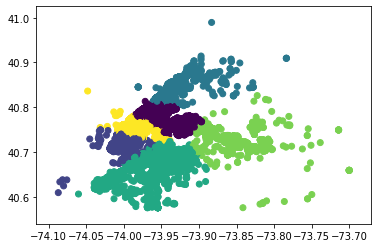

In [22]:
model = KMeans(n_clusters=6)
model.fit(df_xy)
df_k = df_xy.copy()
df_k['label'] = model.labels_
plt.scatter(df['longitude'], df['latitude'], c=df_k['label'])
plt.show()
# let's add this to the model, see if it helps

In [28]:
model = LinearRegression()
df['label'] = df_k['label']
X_cols = ['bedrooms', 'bathrooms', 'dist_from_center', 'label']
y_col = ['price']
df_train = df[df['date'] < datetime.datetime(2016, 6, 1)]
df_test = df[df['date'] >= datetime.datetime(2016, 6, 1)]
X_train = df_train[X_cols]
X_test = df_test[X_cols]
y_train = df_train[y_col]
y_test = df_test[y_col]
model.fit(X_train, y_train)
coeffs = model.coef_[0]
intercept = model.intercept_
y_pred = model.predict(X_test)
print(f'RMSE: {sqrt(mean_squared_error(y_test, y_pred)):.2f}')
print(f'MAE: {mean_absolute_error(y_test, y_pred):.2f}')
print(f'R2: {r2_score(y_test, y_pred):.2f}')
print()
for i in range(len(coeffs)):
  print(f'Coefficient {i + 1}: {coeffs[i]:.2f}')
print(f'Y Intercept: {intercept[0]:.2f}')

RMSE: 1142.42
MAE: 760.89
R2: 0.58

Coefficient 1: 445.34
Coefficient 2: 1955.91
Coefficient 3: -15369.62
Coefficient 4: -32.74
Y Intercept: 1212.51
